@misc{multiobjectdatasets19,
  title={Multi-Object Datasets},
  author={Kabra, Rishabh and Burgess, Chris and Matthey, Loic and
          Kaufman, Raphael Lopez and Greff, Klaus and Reynolds, Malcolm and
          Lerchner, Alexander},
  howpublished={https://github.com/deepmind/multi-object-datasets/},
  year={2019}
}

1. In ce format se gaseste: TFRecords
2. Cate imagini contine: 100000
3. Cate tipuri de obiecte contine: 3
4. Numarul de obiecte este intre 1-11

In [ ]:
# pip install torch wget pandas torchviz matplotlib numpy scipy tensorflow pickle

In [ ]:
# wget -P ./data/input https://storage.googleapis.com/multi-object-datasets/clevr_with_masks/clevr_with_masks_train.tfrecords

In [1]:
import os
import torch
import torchviz
import numpy as np
import pandas as pd
from torch import nn
import tensorflow as tf
from typing import Iterator
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from torchvision import transforms
from multi_object_datasets import clevr_with_masks
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [2]:
import random

class Args():
    def __init__(self):
        # Config elements
        self.batch_size = 10
        self.test_batch_size = 10
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.99
        self.seed = 1
        self.imgs_per_file = 1_000
        self.log_interval = self.imgs_per_file // self.batch_size
        self.shuffle = True
        self.shuffle_buffer_size = 100
        self.cache_size = 7

# Instantiate a configuration
args = Args()

# Use device config
random.seed(args.seed)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [3]:
import re
import pickle
from functools import lru_cache

@lru_cache(maxsize=args.cache_size)
def load_data_file(filepath):
    """
    Receives the relative path to a file, and uses LRU caching strategy to return the result.
    """
    with open(filepath, 'rb') as handle:
        # Load the data file from disk into memory
        data = pickle.load(handle)
        print(f'Loaded {filepath} in memory.')
        
        # Iterate through the rows in the data file
        for entry in data:
            # Transform relevant columns to tensors
            for key in ['image', 'mask']:
                # Transform data to Pytorch tensors
                entry[key] = torch.from_numpy(entry[key])

                # Remove extra nesting
                entry[key] = entry[key].squeeze(0)

                # Permute dimensions according to Pytorch requirements
                if key == 'image':
                    # Permute dimensions from (H, W, C) to (C, H, W)
                    entry[key] = entry[key].permute(2, 0, 1)
                elif key == 'mask':
                    # Permute dimensions from (N, H, W, C) to (N, C, H, W)
                    entry[key] = entry[key].permute(0, 3, 1, 2)

            # Get list of visible objects on screen
            entry['count'] = torch.from_numpy(entry['visibility'])

            # Remove extra nesting
            entry['count'] = entry['count'].squeeze(0)

            # Sum the number of visible objects
            entry['count'] = entry['count'].sum()

            # Remove unnecessary columns
            for key in set(entry.keys()) - {'image', 'mask', 'count'}:
                entry[key] = None
                
    # Return the processed data in Pytorch format
    return data

def preprocess(data):
    # Format the data to be in [0, 1]
    return data.float() / 255.0

class SegmentationDataset(Dataset):
    def __init__(self, mode='train', imgs_per_file=args.imgs_per_file, shuffle=args.shuffle, seed=args.seed):
        # Specify the directory containing all data
        self.__input_dir = f'./data/input/train_test_clevr_pkls'

        # Fetch the relative paths to the data files
        self.__data_files = [f'{self.__input_dir}/{fname}' for fname in os.listdir(self.__input_dir) if re.search(mode, fname)]
        
        # Specify how many entries are in one file
        self.__imgs_per_file = imgs_per_file

        # Use specified seed to shuffle the data
        if shuffle:
            random.seed(seed)
            random.shuffle(self.__data_files)

    def __getitem__(self, index) -> torch.Tensor:
        """
        Reads the image at position 'index % imgs_per_file' in the 'index / imgs_per_file' file.
        Returns a Tensor.
        """
        # Load the file in memory using a caching strategy
        data = load_data_file(self.__data_files[index // self.__imgs_per_file])
        
        # Select the item at 'index % imgs_per_file'
        item = data[index % self.__imgs_per_file]

        # Return a pair containing (image, mask)
        return item['image'], item['mask'], item['count']

    def __len__(self):
        """
        Return the size of this dataset. 
        This is given by the number of images in all data files.
        """
        return len(self.__data_files) * self.__imgs_per_file
        

In [4]:
train_dataset = SegmentationDataset(mode='train')
train_loader = DataLoader(train_dataset, args.batch_size, args.shuffle)

Loaded ./data/input/train_test_clevr_pkls/train_clevr_7000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_4000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_2000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_3000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_6000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_5000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_1000.pkl in memory.


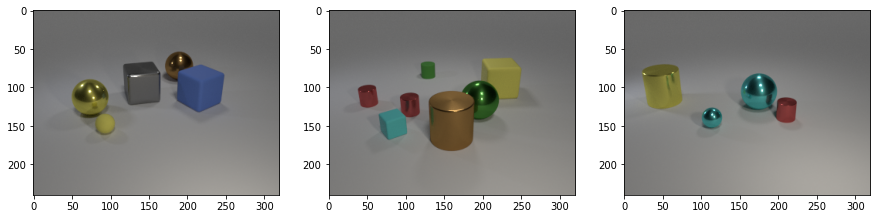

In [5]:
# Define a new figure
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)

# Print some images
for idx, (images, masks, counts) in enumerate(train_loader):
    if idx >= 0 and idx <= 2:
        # Print the images
        plt.subplot(1, 3, idx + 1)
        plt.imshow(images[0].to(torch.uint8).permute(1, 2, 0))

# Show the plot
plt.show()

In [6]:
class ConvBlock(torch.nn.Module):
    """ Apply consecutive convolutions, followed by an activation function. """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, batch_norm=True, **kwargs):
        super().__init__()
        # Batch normalization flag
        self.__has_batch_norm = batch_norm

        # Convolutions
        self.__conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=True, **kwargs)
        self.__conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding, bias=True, **kwargs)

        # Batch normalization
        if self.__has_batch_norm:
            self.__batch_norm1 = torch.nn.BatchNorm2d(num_features=in_channels)
            self.__batch_norm2 = torch.nn.BatchNorm2d(num_features=out_channels)

        # Activation function
        self.__activ_fun = torch.nn.ReLU()

    def forward(self, x):
        # Apply a batch normalization layer
        if self.__has_batch_norm:
            x = self.__batch_norm1(x)
            
        # Apply the first convolution
        x = self.__activ_fun(self.__conv1(x))

        # Apply a batch normalization layer
        if self.__has_batch_norm:
            x = self.__batch_norm2(x)

        # Apply the second convolution
        x = self.__activ_fun(self.__conv2(x))
        return x

In [7]:
class DownSample(torch.nn.Module):
    """ Apply max pooling operation to downsample the image and then a convolution block. """
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, dropout=False, p=0.1, **kwargs):
        super().__init__()
        # Dropout flag
        self.__has_dropout = dropout

        # Define the max pooling layer
        self.__pool = torch.nn.MaxPool2d(kernel_size=kernel_size, stride=stride, **kwargs)

        # Optional dropout layer
        if self.__has_dropout:
            self.__dropout = torch.nn.Dropout2d(p)
        
        # Define the convolution block
        self.__conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        # Apply a pooling operation, which downscales the image
        x = self.__pool(x)

        # Optionally apply a dropout regularization layer
        if self.__has_dropout:
            x = self.__dropout(x)

        # Apply a convolutional block
        x = self.__conv_block(x)
        return x

In [8]:
class UpSample(torch.nn.Module):
    """ 
    Apply a transpose convolution operation to upscale the image and reduce the number of channels. 
    Add skip connection: concatenate the current output with the output of a previous layer.
    Then apply a convolution block.
    """
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, dropout=False, p=0.1, **kwargs):
        super().__init__()
        # Dropout flag
        self.__has_dropout = dropout

        # Define the transpose convolution layer
        self.__tconv = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, bias=True, **kwargs)

        # Optional dropout layer
        if dropout:
            self.__dropout = torch.nn.Dropout2d(p)

        # Create a convolutional block
        self.__conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, x_prev):
        # Apply a transpose convolution, which upscales the image
        x = self.__tconv(x)

        # Add a skip connection to a previous symmetrical layer
        x = torch.cat((x_prev, x), dim=1)

        # Optionally apply a dropout regularization layer
        if self.__has_dropout:
            x = self.__dropout(x)

        # Apply a convolutional block
        x = self.__conv_block(x)
        return x

In [9]:
class OutConv(torch.nn.Module):
    """ Apply an output convolution operation to change the number of channels. """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, **kwargs):
        super().__init__()
        self.__conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=True, **kwargs)

    def forward(self, x):
        x = self.__conv(x)
        return x

In [10]:
class UNetCNN(torch.nn.Module):
    def __init__(self, n_filters=8):
        super().__init__()
        # Input Convolutional Layer
        self.__in_conv_block = ConvBlock(3, n_filters)

        # Encoder Layers
        self.__down_sample1 = DownSample(n_filters, n_filters * 2)
        self.__down_sample2 = DownSample(n_filters * 2, n_filters * 4)
        self.__down_sample3 = DownSample(n_filters * 4, n_filters * 8)
        self.__down_sample4 = DownSample(n_filters * 8, n_filters * 16)

        # Decoder Layers
        self.__up_sample4 = UpSample(n_filters * 16, n_filters * 8)
        self.__up_sample3 = UpSample(n_filters * 8, n_filters * 4)
        self.__up_sample2 = UpSample(n_filters * 4, n_filters * 2)
        self.__up_sample1 = UpSample(n_filters * 2, n_filters)

        # Output Convolutional Layer
        self.__out_conv_block = OutConv(n_filters, 3)

    def forward(self, x):
        # Encode the data
        encoder_1 = self.__in_conv_block(x)
        encoder_2 = self.__down_sample1(encoder_1)
        encoder_3 = self.__down_sample2(encoder_2)
        encoder_4 = self.__down_sample3(encoder_3)

        # Obtain the bottleneck of the network
        bottleneck = self.__down_sample4(encoder_4)

        # Decode the bottleneck
        decoder_4 = self.__up_sample4(bottleneck, encoder_4)
        decoder_3 = self.__up_sample3(decoder_4, encoder_3)
        decoder_2 = self.__up_sample2(decoder_3, encoder_2)
        decoder_1 = self.__up_sample1(decoder_2, encoder_1)
        
        # Reduce the number of channels
        output = self.__out_conv_block(decoder_1)
        return output
        

In [11]:
def train(args, model, device, train_loader, optimizer, criterion, epoch):
    # Set the model to training mode
    model.train()

    # Retain a history of losses
    all_losses = []

    # Iterate through the data loarder and train the model
    for batch_idx, (images, masks, counts) in enumerate(train_loader):
        # Send the data to the available GPU
        images, masks = images.to(device), masks.to(device)

        # Preprocess the images
        images = preprocess(images)
        
        # Reset the gradients back to zero before calculating new loss
        optimizer.zero_grad()

        # Compute the output of the model
        output = model(images)

        # Calculate the loss accordingly
        loss = criterion(output, images)

        # Add the current loss to the history
        all_losses.append(loss.cpu())

        # Use backpropagation to calculate the new gradients
        loss.backward()

        # Use a custom optimizer to adjuts the parameters of the model
        optimizer.step()

        # Show updates regularly
        if batch_idx % args.log_interval == 0 or batch_idx == len(train_loader) - 1:
            print(f'Train Epoch: {epoch} ', end='')
            print(f'[{batch_idx * images.shape[0]}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]', end='')
            print(f'\tLoss: {loss.item()}')

    # Return the losses of this epoch
    return torch.tensor(all_losses).mean()

In [12]:
def plot_loss(loss, label, title, xlab, ylab, color='blue', **kwargs):
    # Plot the loss evolution as a 2D Line
    plt.plot(loss, label=label, color=color, **kwargs)
    
    # Specify the title
    plt.title(title)

    # Specify the Ox label
    plt.xlabel(xlab)

    # Specify the Oy label
    plt.ylabel(ylab)

    # Specify the legend of the plot
    plt.legend()

In [13]:
# Define the datasets for both training and testing
test_dataset = SegmentationDataset(mode='test')
train_dataset = SegmentationDataset(mode='train')

In [14]:
# Define the dataloaders for both training and testing
test_loader = DataLoader(test_dataset, args.test_batch_size, args.shuffle)
train_loader = DataLoader(train_dataset, args.batch_size, args.shuffle)

In [15]:
# Instantiate the model and send it to the GPU
model = UNetCNN(n_filters=8).to(device)

# Define a custom optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.99)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001) # MSELoss, 4 filtre
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01) # Asta + mse loss very good, 8 filtre

# Specify a custom loss function
# criterion = torch.nn.L1Loss()
criterion = torch.nn.MSELoss()

Train Epoch: 0 [0/7000 (0%)]	Loss: 0.23920084536075592
Train Epoch: 0 [1000/7000 (14%)]	Loss: 0.0013065510429441929
Train Epoch: 0 [2000/7000 (29%)]	Loss: 0.0010126811685040593
Train Epoch: 0 [3000/7000 (43%)]	Loss: 0.000910117058083415
Train Epoch: 0 [4000/7000 (57%)]	Loss: 0.0005923202261328697
Train Epoch: 0 [5000/7000 (71%)]	Loss: 0.00043528206879273057
Train Epoch: 0 [6000/7000 (86%)]	Loss: 0.0004473254957702011
Train Epoch: 0 [6990/7000 (100%)]	Loss: 0.0003516180149745196

Train Epoch: 1 [0/7000 (0%)]	Loss: 0.00042638846207410097
Train Epoch: 1 [1000/7000 (14%)]	Loss: 0.0002697577583603561
Train Epoch: 1 [2000/7000 (29%)]	Loss: 0.0002379415527684614
Train Epoch: 1 [3000/7000 (43%)]	Loss: 0.00029545288998633623
Train Epoch: 1 [4000/7000 (57%)]	Loss: 0.00026249614893458784
Train Epoch: 1 [5000/7000 (71%)]	Loss: 0.0003922227770090103
Train Epoch: 1 [6000/7000 (86%)]	Loss: 0.00019301190332043916
Train Epoch: 1 [6990/7000 (100%)]	Loss: 0.00026581360725685954

Train Epoch: 2 [0/7000 (0

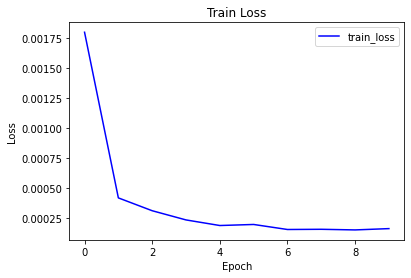

In [16]:
# Retain the loss evolution
losses_train = []

# Train the model for a number of epochs
for epoch in range(args.epochs):
    # Train the model for one epoch
    train_loss = train(args, model, device, train_loader, optimizer, criterion, epoch)

    # Retain the current loss
    losses_train.append(train_loss)

    # Separate the outputs
    print()

# Plot the loss evolution
plot_loss(losses_train, 'train_loss', 'Train Loss', 'Epoch', 'Loss')

In [19]:
# Specify the path where the weights will be saved to
MODEL_WEIGHTS_PATH = './model/u-net.pt'

In [20]:
# Save the weights on disk
torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)

In [21]:
# Instantiate the model and send it to the GPU
model = UNetCNN(n_filters=8).to(device)

# Load the model trained parameters in memory
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

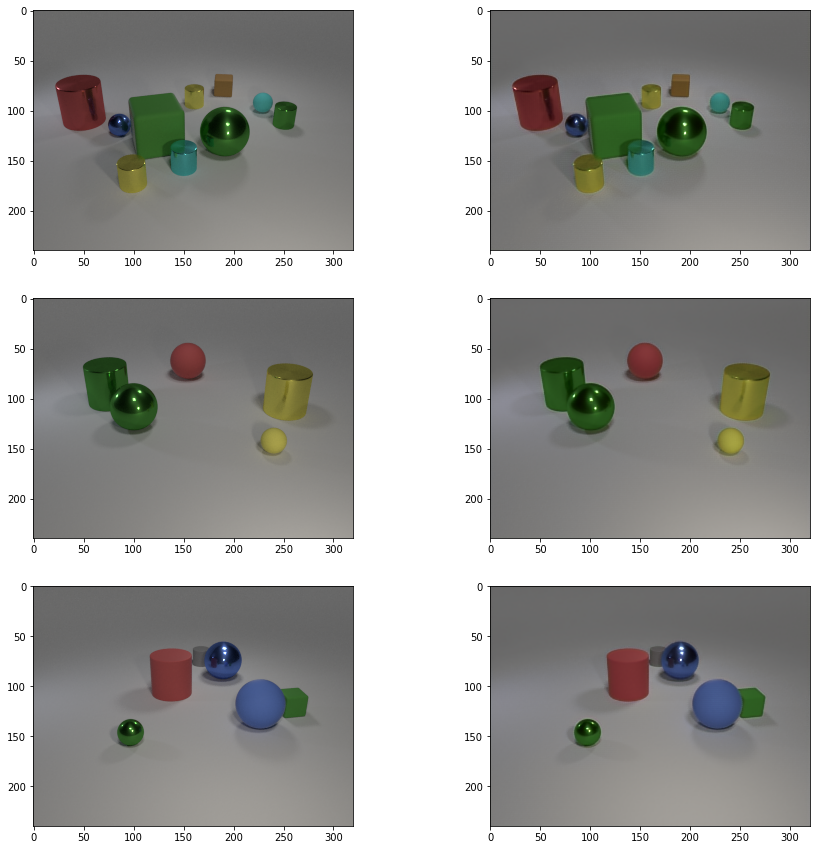

In [24]:
# Set the model to evaluation mode
model.eval()

# Create a new figure
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)

# Set the number of samples
current_subplot = 1
total_subplots = 3

for batch_idx, (images, masks, counts) in enumerate(test_loader):
    if batch_idx == total_subplots:
        break

    # Specify the input image
    img_true = images[0]

    # Calculate the predicted image and transform it from [0, 1] -> [0, 255]
    img_pred = (model(preprocess(img_true).to(device).unsqueeze(0)) * 255.0)

    # Clamp the values in case the values exceed the allocated interval [0, 255]
    img_pred = torch.clamp(img_pred, 0.0, 255.0).to(torch.uint8).cpu()
    
    # Plot input image
    plt.subplot(total_subplots, 2, current_subplot)
    plt.imshow(img_true.permute(1, 2, 0))
    current_subplot += 1

    # Plot output image
    plt.subplot(total_subplots, 2, current_subplot)
    plt.imshow(img_pred.squeeze(0).permute(1, 2, 0))
    current_subplot += 1

# Plot the images
plt.show()